# Funzione sigmoide

In [1]:
from IPython.display import Math

Math(r'f(x,a,b,c) = \frac{c}{1 + e^{-(x-b)/a}}')

<IPython.core.display.Math object>

- a si riferisce alla velocità di infezione

- b è il giorno col maggior numero di contagi

- c è il numero totale di persone contagiate alla fine della pandemia

# Funzione esponenziale

In [2]:
Math(r'f(x,a,b,c) = a*e^{b(x-c)}')

<IPython.core.display.Math object>

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from matplotlib import cm

In [4]:
def preProcessing(dataframe,dataframe31Gen, value):
    dataframe = dataframe.loc[:, ['data', 'totale_casi']]

    dataframe['data'] = dataframe['data'][:].replace('T', ' ', regex=True)

    df = dataframe[:-value]
    points = dataframe[-value:]

    df = df.append(dataframe31Gen)
    df.sort_values(by=['data'], inplace=True)

    FMT = '%Y-%m-%d %H:%M:%S'
    #df['range'] = df['range'].str.replace(',', '-')
    date = df['data']
    date2 = points['data']
    df['data'] = date.map(lambda x: (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)

    points['data'] = date2.map(lambda x: (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01 00:00:00", FMT)).days)

    return df, points, dataframe['data']

In [5]:
def logistic_model(x, a, b, c):
    return c / (1 + np.exp(-(x - b) / a))

In [6]:
def exponential_model(x, a, b, c):
    return a*np.exp(b*(x-c))

In [7]:
def fit(data, p0):
    x = list(data.iloc[:, 0])
    y = list(data.iloc[:, 1])
    fit = curve_fit(logistic_model, x, y, p0)
    errors = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]
    return x, y, fit, errors

In [8]:
def exp_fit(data, p0):
    x = list(data.iloc[:, 0])
    y = list(data.iloc[:, 1])
    fit = curve_fit(exponential_model, x, y, p0)
    errors = [np.sqrt(fit[1][i][i]) for i in [0, 1, 2]]
    return x, y, fit, errors

In [9]:
def expected_infection_end(x, a, b, c):
    end = fsolve(lambda x: logistic_model(x, a, b, c) - int(c), b)
    end = np.ndarray.item(end)
    end = int(round(end, 0))
    return end

In [10]:
def exp_expected_infection_end(x, a, b, c):
    end = fsolve(lambda x: exponential_model(x, a, b, c) - int(c), b)
    end = np.ndarray.item(end)
    end = int(round(end, 0))
    return end

In [11]:
def difference_between_predict_days (dati_y_logistic):
    lista = list()
    for b in range(0, len(dati_y_logistic)):
        if b == 0:
            lista.append(dati_y_logistic[0])
        else:
            lista.append(dati_y_logistic[b] - dati_y_logistic[b - 1])
    return lista

In [12]:
def plot (x, y, end, c, points):

    x_ = points["data"]
    x_ = list(x_)
    y_ = points["totale_casi"]
    y_ = list(y_)

    plt.subplots(figsize=(25, 10))

    pred_x = list(range(max(x), end))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)

    # Real data
    plt.scatter(x, y, label="Casi dati in input", color="red", s=65)
    # Predicted logistic curve
    plt.plot(x + pred_x, [logistic_model(i, fit[0][0], fit[0][1], fit[0][2]) for i in x + pred_x],
             label="Contagi previsti (misure funzionano)",linewidth=2.3)
    plt.plot(x + pred_x, [exponential_model(i, exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in x + pred_x],
             label="Contagi previsti (misure falliscono)",linewidth=2.3)

    plt.scatter(x_,y_, label ="Casi non dati in input",  color = 'black', s=65)

    plt.title('Andamento e predizione casi totali in Italia',weight='bold')
    plt.xlabel("Giorni dall'1 Gennaio 2020", fontsize = 15)
    plt.ylabel("Numero totale di contagiati",fontsize = 15)
    plt.ylim((min(y) * 1.2, c * 1.3))
    plt.axvline(x=54, color='green', label='Università/scuole zone rosse', alpha=0.6, linestyle='dashed')
    plt.axvline(x=62, color='black', alpha=0.6, label='Università/scuole tutta Italia', linestyle='dashed')
    plt.axvline(x=65, color='orange', alpha=0.6, label='Smart working/nuove misure', linestyle='dashed')
    plt.axvline(x=68, color='violet', alpha=0.6, label='Locali tutta Italia', linestyle='dashed')
    plt.axvline(x=69, color='red', alpha=0.6, label='Italia zona rossa', linestyle='dashed')
    plt.axvline(x=71, color='black', alpha=0.6, label='Chiuse tutte attività', linestyle='dashed')

    plt.axvline(x=69 + 14, color='red', alpha=1, linestyle='dashed')

    plt.legend()
    plt.show()

In [13]:
def conv (value):
    value = int(round(value,0))
    return value

In [14]:
def residual(x,y):
    y_pred_logistic = [logistic_model(i, fit[0][0], fit[0][1], fit[0][2]) for i in x]
    y_pred_exp = [exponential_model(i, exp_fit[0][0], exp_fit[0][1], exp_fit[0][2]) for i in x]
    logistic_mse = mean_squared_error(y, y_pred_logistic)
    exp_mse = mean_squared_error(y, y_pred_exp)
    return logistic_mse, exp_mse

In [15]:
def plot_bar(x,y,title):
    l = list()
    for a in x:
        l.append(a[:10])
    l = np.array(l)
    y = np.array(y)
    plt.subplots(figsize=(25, 10))
    plt.title(title, fontsize = 16, weight='bold')
    plt.tick_params(labelrotation=90,labelsize=10)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.bar(l, y, color=(0.3, 0.5, 0.8))
    for x, y in zip(l, y):
        label = "{:}".format(y)
        plt.annotate(label,  
                     (x, y),  
                     textcoords="offset points",  
                     xytext=(0, 4),  
                     ha='center', weight='bold',color='black', fontsize= 8.5)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


LOGISTIC MODEL
Numero di persone contagiate alla fine dell'epidemia: 223186
Con un errore di 1417
Intervallo contagiati compreso tra 221769 e 224603
Giorno di picco contagiati fra -51 giorni
Fine dell'epidemia fra 76 giorni
Logistic model MSE:  30742154.467873853

Exponential model MSE:  1117740652.6630635


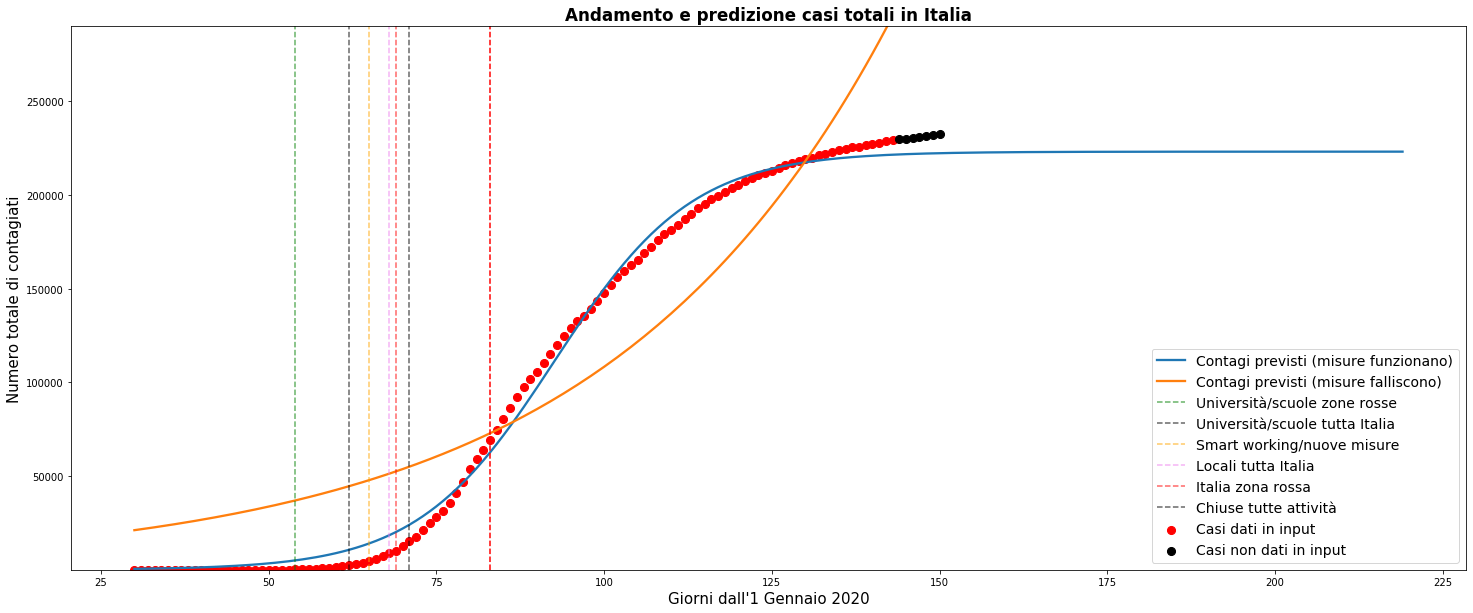

In [16]:
if __name__ == '__main__':


    url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
    dataframe = pd.read_csv(url)
    value = 7
    dataframe31Gen = pd.read_csv('/Users/scicchi/PycharmProjects/COVID-19 statistics and prediction/data/31Gen23Feb.csv')
    df, points, data = preProcessing(dataframe,dataframe31Gen, value)
    p0_logical = [2, 100, 20000]
    p0_exp = [1, 1, 21]

    x, y, fit , errors = fit(df,p0_logical)
    a = fit [0][0]
    b = fit[0][1]
    c = fit[0][2]

    print("LOGISTIC MODEL")
    print("Numero di persone contagiate alla fine dell'epidemia:", conv(c))
    print('Con un errore di',  conv(errors[2]))
    print("Intervallo contagiati compreso tra %s e %s"   %(conv(c - errors[2]), conv(c + errors[2])))

    end = expected_infection_end(df, a, b, c)
    print("Giorno di picco contagiati fra %s giorni" %(conv(b) - x[-1]-1))

    print("Fine dell'epidemia fra %s giorni" %(conv(end)-x[-1]-1))

    exp_x, exp_y, exp_fit, exp_errors = exp_fit(df, p0_exp)
    exp_a = exp_fit [0][0]
    exp_b = exp_fit[0][1]
    exp_c= exp_fit[0][2]

    #print("EXPONENTIAL MODEL")
    #print("Numero di persone contagiate alla fine dell'epidemia:", conv(exp_c))
    #print('Con un errore di', conv(exp_errors[2]))
    #print("Intervallo contagiati compreso tra %s e %s" % (conv(exp_c - exp_errors[2]), conv(exp_c + exp_errors[2])))

    exp_end = exp_expected_infection_end(df, exp_a, exp_b, exp_c)
    #print("Giorno di picco contagiati fra %s giorni" % (conv(exp_c) - x[-1] - 1))

    #print("Fine dell'epidemia fra %s giorni" % (conv(exp_end) - x[-1] - 1))

    logistic_mse,exp_mse =  residual(x,y)
    print("Logistic model MSE: ",logistic_mse)
    print()
    print("Exponential model MSE: ", exp_mse)
    plot(x, y, end, c, points)

In [17]:
### STATISTICHE GIORNALIERE ###

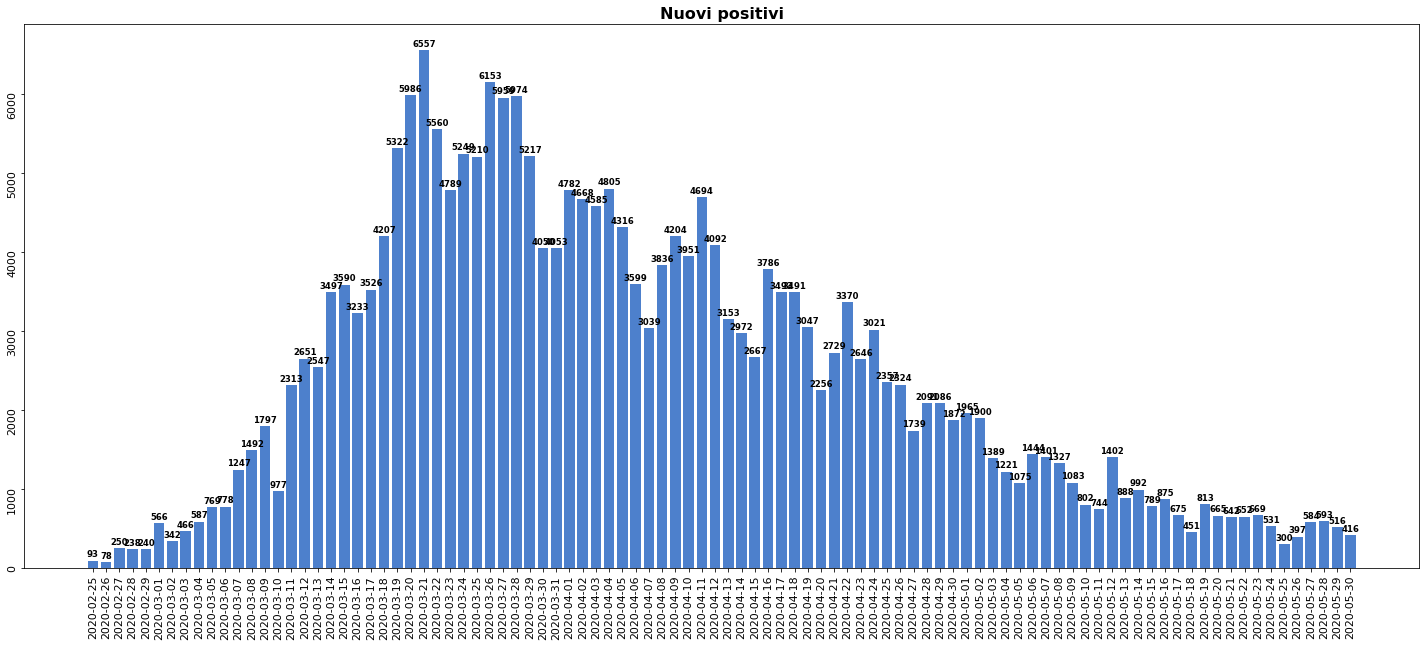

In [18]:
plot_bar(data[1:],dataframe['nuovi_positivi'][1:],'Nuovi positivi')

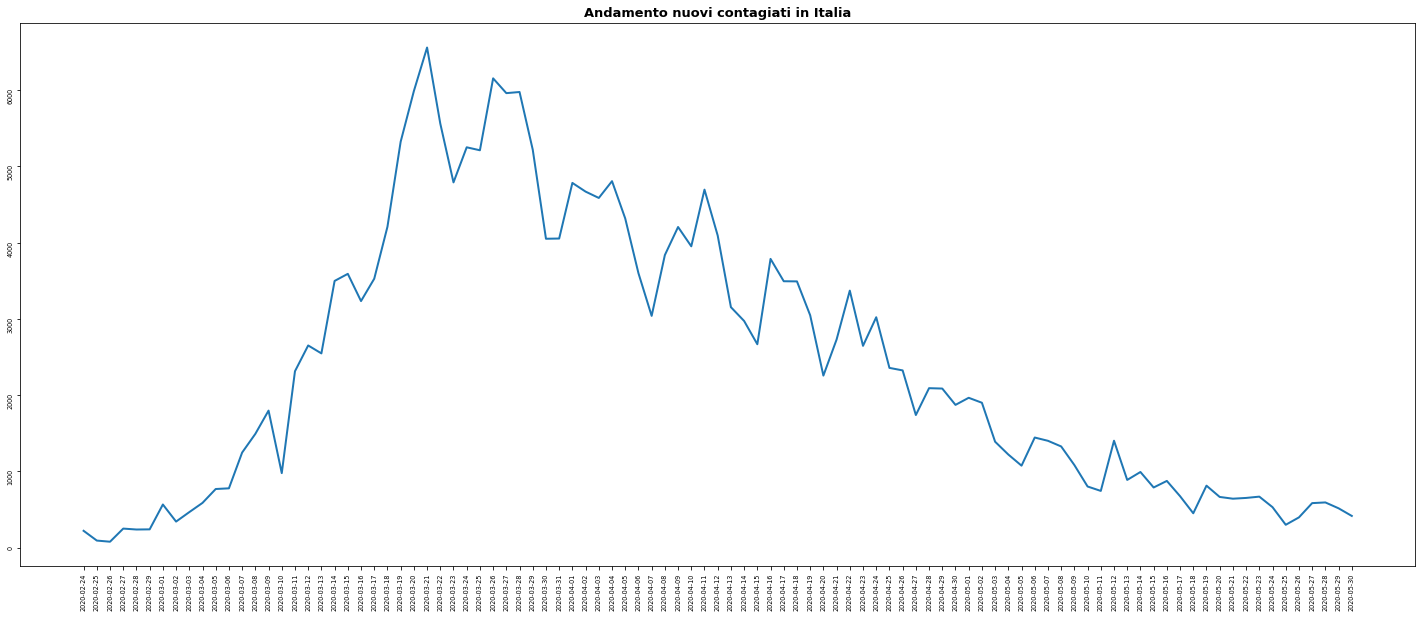

In [19]:
totale_casi = dataframe.loc[:, ['data', 'nuovi_positivi']]
title = "Andamento nuovi contagiati in Italia"

l = list()
for a in data:
    l.append(a[:10])
l = np.array(l)
y = np.array(totale_casi['nuovi_positivi'])
plt.subplots(figsize=(25, 10))
plt.xticks(fontsize=6.5)
plt.title(title, fontsize=13, weight='bold')
plt.tick_params(labelrotation=90, labelsize=6.5)
plt.plot(l,y,lw = 2)
plt.show()

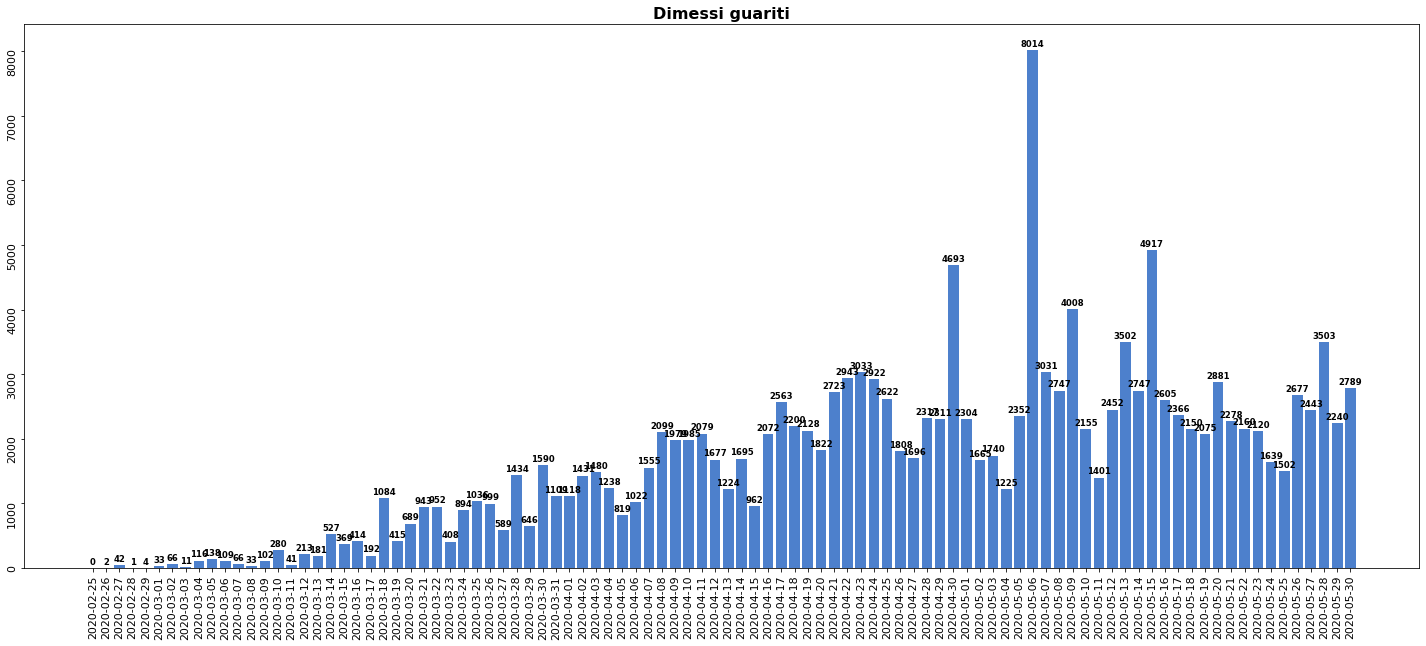

In [20]:
totale_casi = dataframe.loc[:, ['data', 'dimessi_guariti']]
totale_casi = totale_casi.set_index('data').diff().reset_index()
plot_bar(data[1:], totale_casi['dimessi_guariti'][1:].astype(int), 'Dimessi guariti')

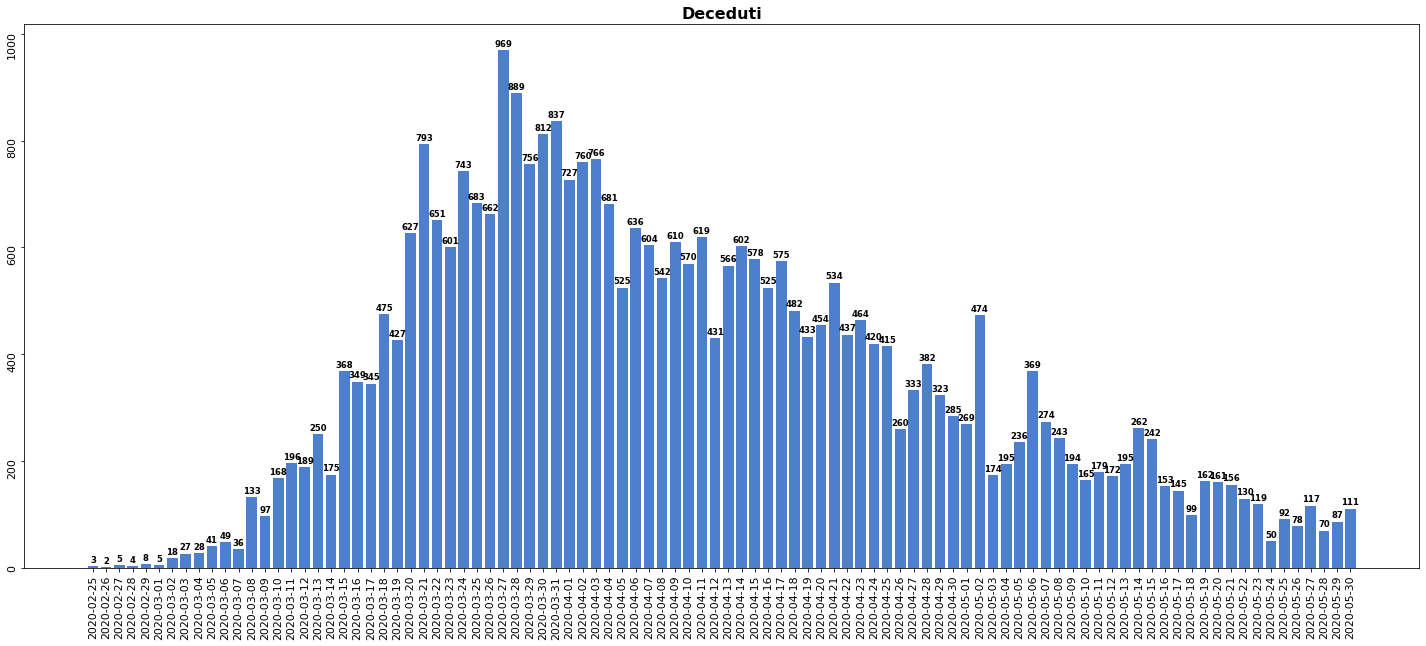

In [21]:
totale_casi = dataframe.loc[:, ['data', 'deceduti']]
totale_casi = totale_casi.set_index('data').diff().reset_index()
plot_bar(data[1:], totale_casi['deceduti'][1:].astype(int), 'Deceduti')

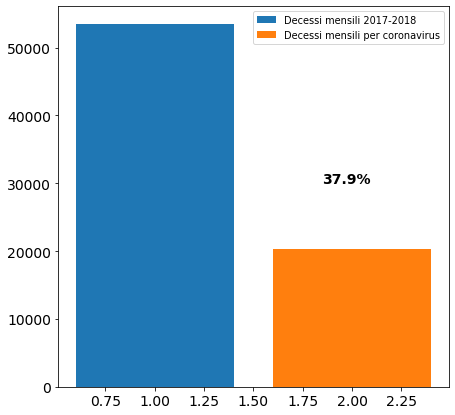

In [22]:
media_morti_italia_2017_2018 = 641097
morti_covid_19marzo_19aprile = 23660 - 3405
media_mensile_2017_2018 = media_morti_italia_2017_2018 / 12
perc_confronto_covid_normalità_mensile = (morti_covid_19marzo_19aprile / media_mensile_2017_2018) * 100
plt.bar(1, media_mensile_2017_2018,label = 'Decessi mensili 2017-2018')
plt.bar(2, morti_covid_19marzo_19aprile,label='Decessi mensili per coronavirus')
plt.text(1.85, 30000, '%.1f' % perc_confronto_covid_normalità_mensile + '%',
         weight='bold', label = 'Percentuale del rapporto')
plt.legend(fontsize='x-small')
plt.show()

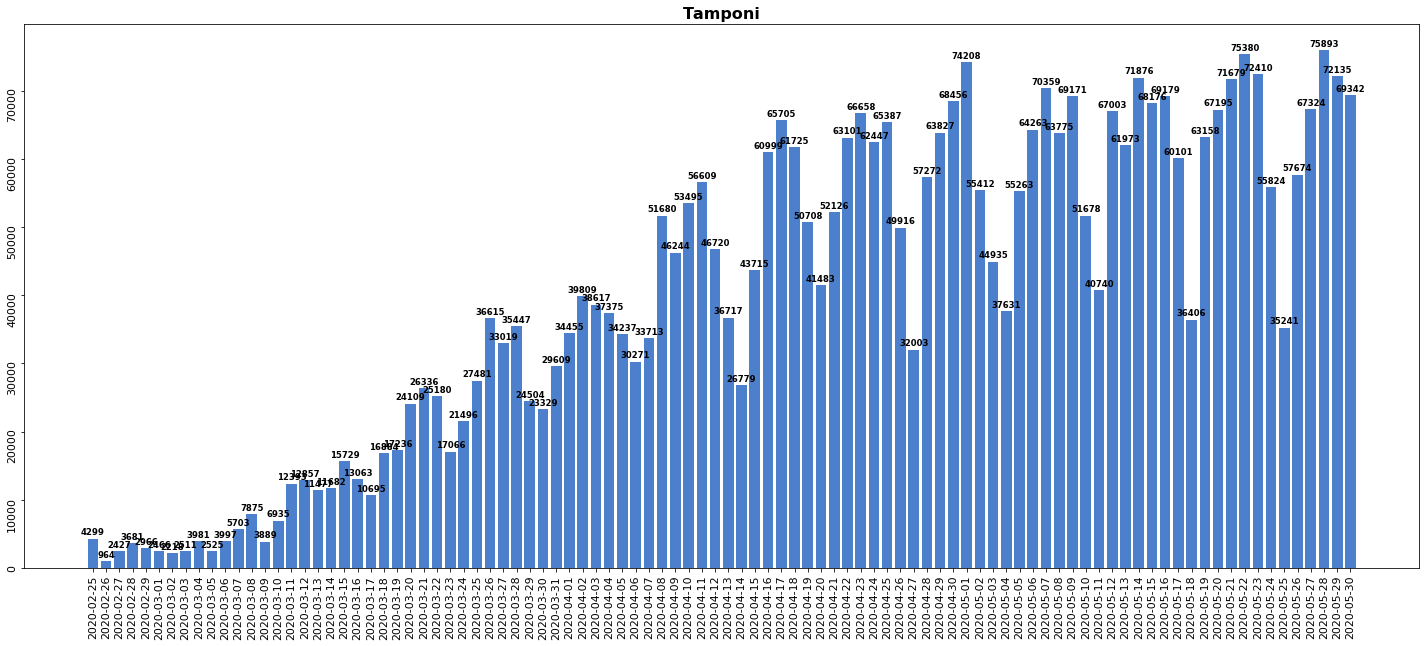

In [23]:
totale_casi = dataframe.loc[:, ['data', 'tamponi']]
totale_casi = totale_casi.set_index('data').diff().reset_index()
plot_bar(data[1:], totale_casi['tamponi'][1:].astype(int), 'Tamponi')

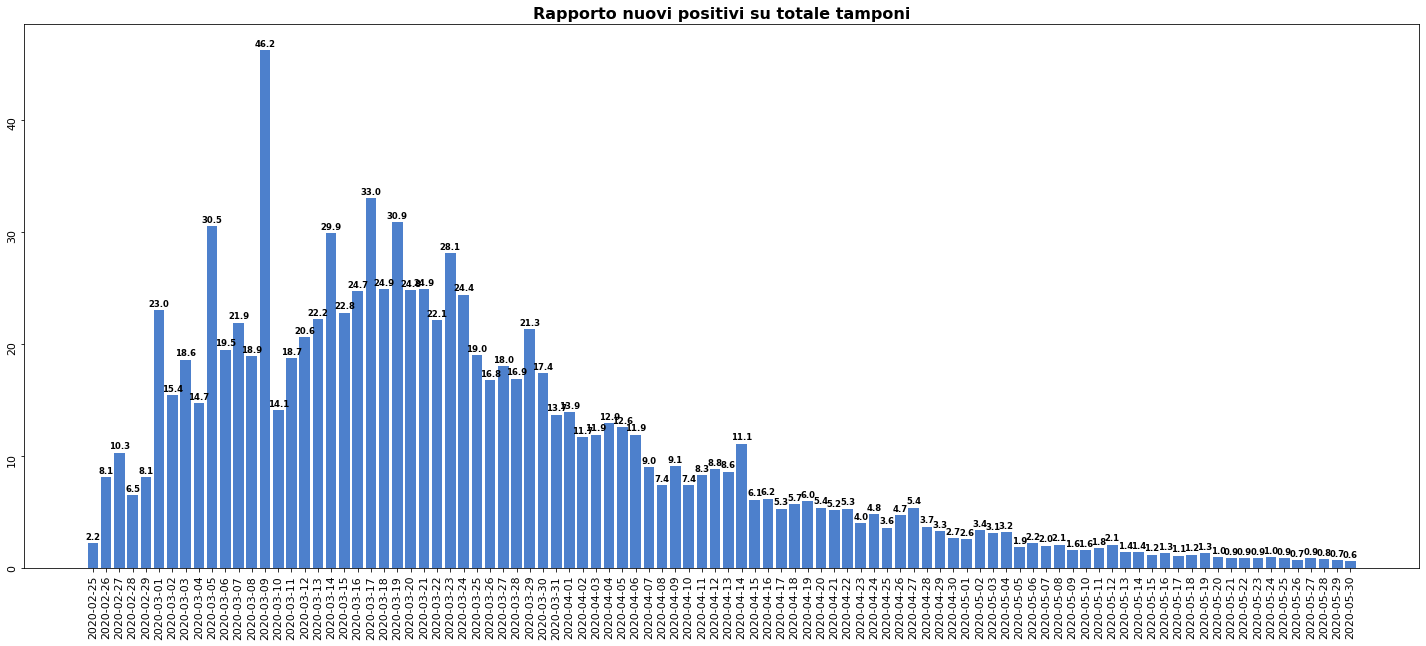

In [24]:
rapporto = dataframe['nuovi_positivi'] / totale_casi['tamponi']
rapporto = rapporto * 100
rapporto = rapporto.round(1)
plot_bar(data[1:], rapporto[1:], 'Rapporto nuovi positivi su totale tamponi')

# TUTTE LE REGIONI



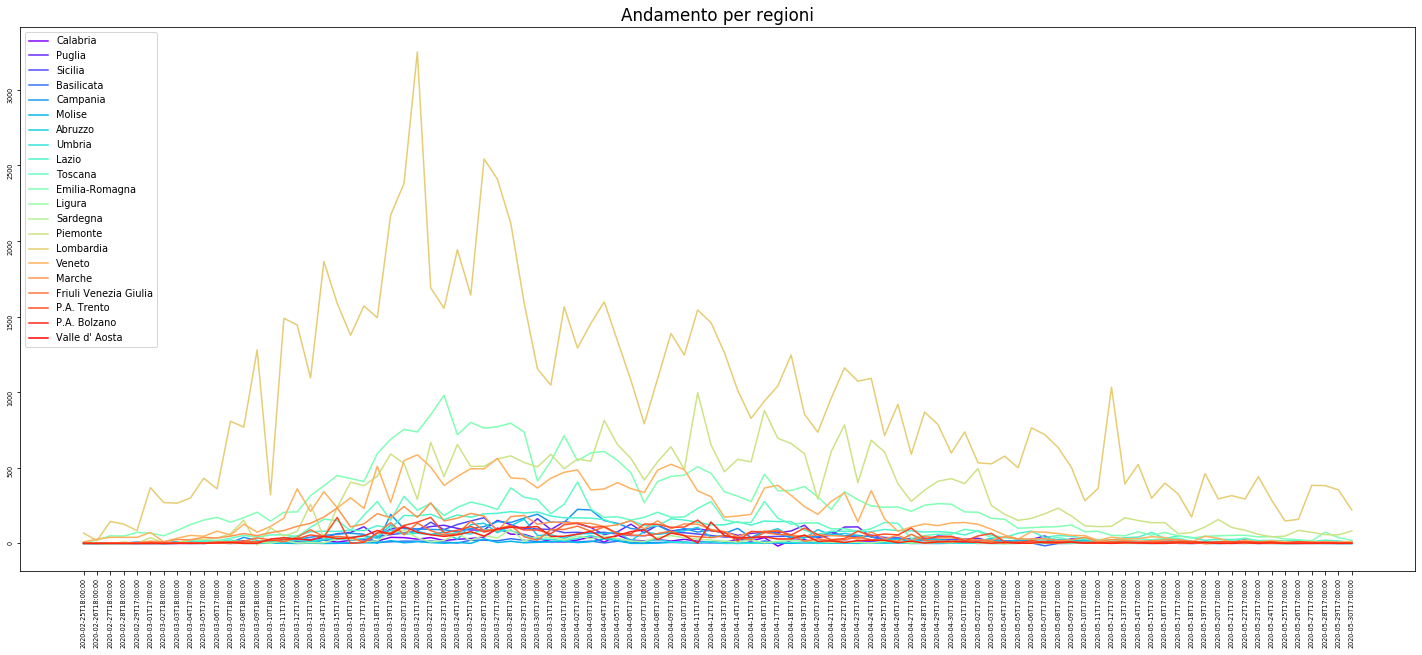

In [25]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv"
dataframeT = pd.read_csv(url)
    
lista = ['Calabria','Puglia','Sicilia','Basilicata','Campania','Molise','Abruzzo',
         'Umbria','Lazio','Toscana','Emilia-Romagna','Ligura','Sardegna','Piemonte',
         'Lombardia','Veneto','Marche','Friuli Venezia Giulia','P.A. Trento','P.A. Bolzano',
         'Valle d\' Aosta']

color = cm.rainbow(np.linspace(0, 1, len(lista)))

plt.subplots(figsize=(25, 10))

for regione, colore in zip(lista,color):
    if regione == 'Lombardia':
        dati = dataframeT[dataframeT.denominazione_regione == regione]
        dati.at[324, 'nuovi_positivi'] = 322
        dati.at[492, 'nuovi_positivi'] = 1493
        plt.title('Andamento per regioni')
        plt.tick_params(labelrotation=90, labelsize=6.5)
        plt.plot(dati['data'][1:], dati['nuovi_positivi'][1:], color=colore, label=regione)
        #plt.yscale('log')
    elif regione == 'Puglia':
        dati = dataframeT[dataframeT.denominazione_regione == regione]
        dati.at[454, 'nuovi_positivi'] = 72
        plt.title('Andamento per regioni')
        plt.tick_params(labelrotation=90, labelsize=6.5)
        plt.plot(dati['data'][1:], dati['nuovi_positivi'][1:], color=colore, label=regione)
        #plt.yscale('log')

    else:
        dati = dataframeT[dataframeT.denominazione_regione == regione]
        plt.title('Andamento per regioni')
        plt.tick_params(labelrotation=90, labelsize=6.5)
        plt.plot(dati['data'][1:], dati['nuovi_positivi'][1:], color=colore, label=regione)
        #plt.yscale('log')

plt.legend(loc='upper left', fontsize='x-small')
plt.show()


# Mortalità principali Paesi

In [ ]:
url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'
dataframe = pd.read_csv(url)

# ITALIA #
italy = dataframe[dataframe.location == 'Italy']
italy_total_cases = italy.total_cases
italy_total_deaths = italy.total_deaths
mortalità_italia = round((italy_total_deaths.tail(1) / italy_total_cases.tail(1)) * 100, 1)

# SPAGNA #
spain = dataframe[dataframe.location == 'Spain']
spain_total_cases = spain.total_cases
spain_total_deaths = spain.total_deaths
mortalità_spagna = round((spain_total_deaths.tail(1) / spain_total_cases.tail(1)) * 100, 1)

# USA #
usa = dataframe[dataframe.location == 'United States']
usa_total_cases = usa.total_cases
usa_total_deaths = usa.total_deaths
mortalità_usa = round((usa_total_deaths.tail(1) / usa_total_cases.tail(1)) * 100, 1)

# FRANCIA #
france = dataframe[dataframe.location == 'France']
france_total_cases = france.total_cases
france_total_deaths = france.total_deaths
mortalità_francia = round((france_total_deaths.tail(1) / france_total_cases.tail(1)) * 100, 1)

# GERMANIA #
germany = dataframe[dataframe.location == 'Germany']
germany_total_cases = germany.total_cases
germany_total_deaths = germany.total_deaths
mortalità_germania = round((germany_total_deaths.tail(1) / germany_total_cases.tail(1)) * 100, 1)

# UK #
uk = dataframe[dataframe.location == 'United Kingdom']
uk_total_cases = uk.total_cases
uk_total_deaths = uk.total_deaths
mortalità_inghilterra = round((uk_total_deaths.tail(1) / uk_total_cases.tail(1)) * 100, 1)

# Netherlands #
netherlands = dataframe[dataframe.location == 'Netherlands']
netherlands_total_cases = netherlands.total_cases
netherlands_total_deaths = netherlands.total_deaths
mortalità_olanda = round((netherlands_total_deaths.tail(1) / netherlands_total_cases.tail(1)) * 100, 1)

# Switzerland #
netherlands = dataframe[dataframe.location == 'Switzerland']
netherlands_total_cases = netherlands.total_cases
netherlands_total_deaths = netherlands.total_deaths
mortalità_svizzera = round((netherlands_total_deaths.tail(1) / netherlands_total_cases.tail(1)) * 100, 1)

# Belgium #
netherlands = dataframe[dataframe.location == 'Belgium']
netherlands_total_cases = netherlands.total_cases
netherlands_total_deaths = netherlands.total_deaths
mortalità_belgio = round((netherlands_total_deaths.tail(1) / netherlands_total_cases.tail(1)) * 100, 1)

# Belgium #
netherlands = dataframe[dataframe.location == 'Portugal']
netherlands_total_cases = netherlands.total_cases
netherlands_total_deaths = netherlands.total_deaths
mortalità_portogallo = round((netherlands_total_deaths.tail(1) / netherlands_total_cases.tail(1)) * 100, 1)

# China #
netherlands = dataframe[dataframe.location == 'China']
netherlands_total_cases = netherlands.total_cases
netherlands_total_deaths = netherlands.total_deaths
mortalità_cina = round((netherlands_total_deaths.tail(1) / netherlands_total_cases.tail(1)) * 100, 1)

# Plot Bar #
plt.subplots(figsize=(25, 10))
plt.bar(1, mortalità_italia, label='Italia')
plt.bar(2, mortalità_belgio, label='Belgio')
plt.bar(3, mortalità_francia, label='Francia')
plt.bar(4, mortalità_germania, label='Germania')
plt.bar(5, mortalità_inghilterra, label='Inghilterra')
plt.bar(6, mortalità_olanda, label='Olanda')
plt.bar(7, mortalità_portogallo, label='Portogallo')
plt.bar(8, mortalità_spagna, label='Spagna')
plt.bar(9, mortalità_svizzera, label='Svizzera')
plt.bar(10, mortalità_usa, label='Usa')
plt.bar(11, mortalità_cina, label='Cina', color = 'k')
plt.title('Percentuale mortalità covid-19')
plt.ylabel('%')
plt.legend(fontsize='small')
plt.show()